In [28]:
import numpy as np
import os, sys, glob
import matplotlib.pyplot as plt
from pycurrents.adcp.rdiraw import Multiread
import jdcal, datetime

In [2]:
%matplotlib inline

## Load raw files using Multiread

In [96]:
pname = '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/'
fname = glob.glob(pname+'rr2017_207*.raw')
fname

['/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_207_65746.raw',
 '/Volumes/wjlee_apl_2/2017_cruises/ADCP_RR1713/raw/os150/rr2017_207_72000.raw']

In [124]:
m = Multiread(fname[0],'os')
data = m.read()

In [125]:
data.pingtype

'bb'

In [126]:
m.list_configs()

# index (ping, NCells, CellSize, Blank, Pulse) nfiles
0    (bb, 80, 4.0, 4.0, 4.0)     1
1    (nb, 60, 8.0, 4.0, 8.0)     1


In [127]:
data.sysconfig

{'angle': 30, 'convex': True, 'kHz': 150, 'up': False}

In [128]:
data.amp.shape

(2668, 80, 4)

In [129]:
data.rVL

rec.array([ (1, 17, 7, 27, 18, 15, 45, 11, 0, 0, 1491, 0, 0, 0, 0, 35, 1044, 0, 0, 52, 0, 0, 0, '', 0, 0, 0, 0),
 (2, 17, 7, 27, 18, 15, 47, 43, 0, 0, 1491, 0, 0, 0, 0, 35, 1029, 0, 0, 52, 0, 0, 0, '', 0, 0, 0, 0),
 (3, 17, 7, 27, 18, 15, 49, 75, 0, 0, 1491, 0, 0, 0, 0, 35, 1051, 0, 0, 52, 0, 0, 0, '', 0, 0, 0, 0),
 ...,
 (2666, 17, 7, 27, 19, 59, 50, 54, 0, 0, 1492, 0, 0, 0, 0, 35, 1057, 0, 0, 52, 0, 0, 0, '', 0, 0, 0, 0),
 (2667, 17, 7, 27, 19, 59, 52, 89, 0, 0, 1492, 0, 0, 0, 0, 35, 1070, 0, 0, 52, 0, 0, 0, '', 0, 0, 0, 0),
 (2668, 17, 7, 27, 19, 59, 55, 24, 0, 0, 1492, 0, 0, 0, 0, 35, 1062, 0, 0, 52, 0, 0, 0, '', 0, 0, 0, 0)], 
          dtype=[('EnsNum', '<u2'), ('Year', 'u1'), ('Month', 'u1'), ('Day', 'u1'), ('Hour', 'u1'), ('Minute', 'u1'), ('Second', 'u1'), ('Hundredths', 'u1'), ('EnsNumMSB', 'u1'), ('BIT', '<u2'), ('SoundSpeed', '<u2'), ('XducerDepth', '<u2'), ('Heading', '<u2'), ('Pitch', '<i2'), ('Roll', '<i2'), ('Salinity', '<u2'), ('Temperature', '<i2'), ('MPT_minutes', 'u

## Function to convert timestamp

In [130]:
def dday2timestr(yr,dday):
    ''' 
    Convert dday to str of timestamp
    yr     data.yearbase
    dday   one or more items in a list from data.dday
    '''
    yr1day = jdcal.gcal2jd(yr,1,1)  # get numbers for start of the year
    gcal = [jdcal.jd2gcal(yr1day[0],yr1day[1]+x) for x in np.nditer(dday)]
    td = [datetime.datetime(year=xx[0],month=xx[1],day=xx[2])+datetime.timedelta(days=xx[-1]) for xx in gcal]
    return [x.strftime('%H:%M:%S') for x in td]

## Function to plot echogram

In [131]:
def plot_echogram(val_mtx,ping_num,time_str,depth,fig_sz):
    '''
    Plot echogram for inspection
    Note this is just for plotting, TL compensation is done outside of this function
    Inputs:
       val_mtx   values to be plotted, can be data.amp or with compensation
       ping_num  the ping number to be plotted (slice indexing)
       time_str  use dday2timestr to get trabsmit time
       depth     data.dep
       fig_sz    (fig width, fig height)
    '''
    fig = plt.figure(figsize=fig_sz)
    plt.imshow(val_mtx.T,aspect='auto',interpolation='none',\
               extent=[0,val_mtx.shape[0],-depth[-1],-depth[0]],\
               vmin=100, vmax=300)
    plt.xticks(ping_num,time_str)
    plt.xlabel('Time (hr:min:sec)',fontsize='large')
    plt.ylabel('Depth (m)',fontsize='large')
    plt.ylim([-data.dep[-1],0])
    plt.colorbar()
    return fig

## Seawater absorption

In [132]:
import arlpy
r = data.dep/np.cos(m.sysconfig['angle']*np.pi/180)  # convert depth to range [m]
SL = 20*np.log10(r)  # spreading loss
alpha_75k = arlpy.utils.mag2db(arlpy.uwa.absorption(75000,depth=100))      # seawater absorption at 75 kHz
alpha_150k = arlpy.utils.mag2db(arlpy.uwa.absorption(150000,depth=100))     # seawater absorption at 150 kHz
AB_75k = 2*alpha_75k*r/1000
AB_150k = 2*alpha_150k*r/1000

## Plot the whole file

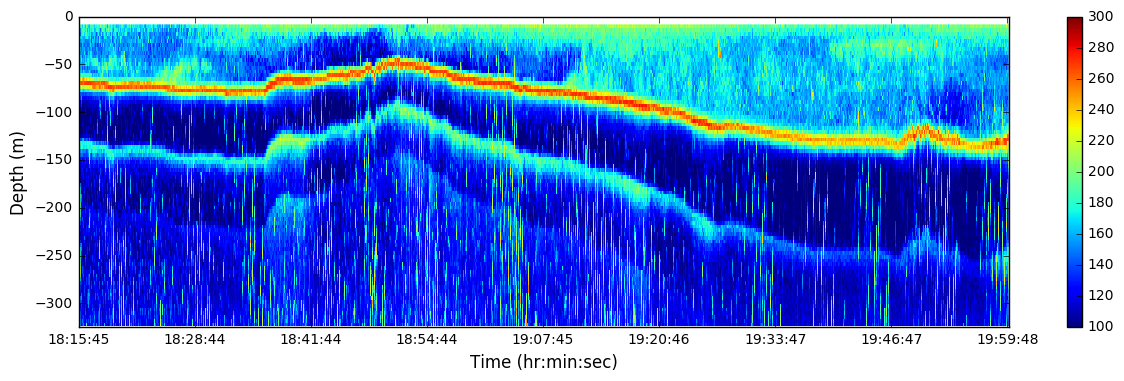

In [133]:
# set up x-axis
ping_jump = int(np.floor(data.dday.shape[0]/8))
ping_num = range(0,data.amp1.shape[0],ping_jump)
time_str = dday2timestr(data.yearbase,data.dday[::ping_jump])

# Plot TL-compensated echogram
fig = plot_echogram(data.amp1+SL-AB_150k,ping_num,time_str,data.dep,(15,4))
fig.savefig(os.path.join('/Users/wujung/code/adcp2Sv/figs/',os.path.basename(fname[1])[0:-4]),dpi=200)

## Plot first 500 pings

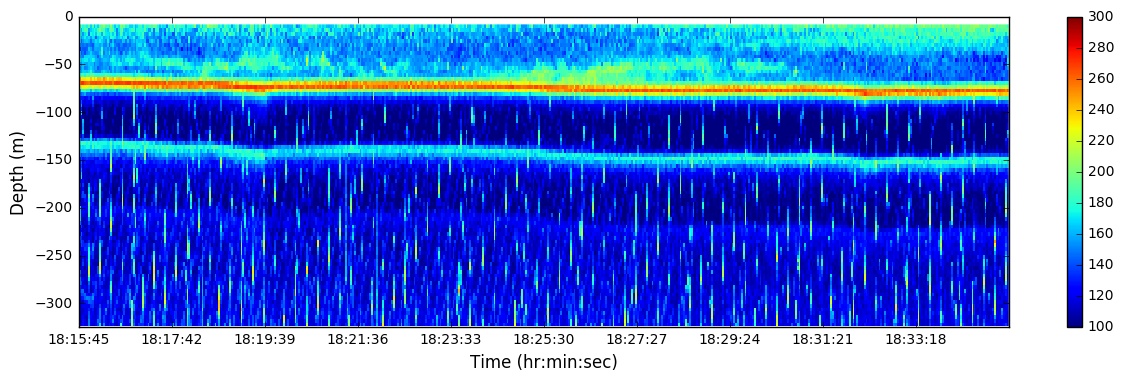

In [134]:
# set up x-axis
ping_jump = 50
ping_num = range(0,500,ping_jump)
time_str = dday2timestr(data.yearbase,data.dday[::ping_jump])

# Plot TL-compensated echogram
fig = plot_echogram(data.amp1[0:500,:]+SL-AB_150k,ping_num,time_str,data.dep,(15,4))
fig.savefig(os.path.join('/Users/wujung/code/adcp2Sv/figs/',os.path.basename(fname[1])[0:-4])+'_first500ping',dpi=200)